# Take home data challenge project report: daily revenue prediction for a set of shared bike stations

## Business Understanding:
Bicycle sharing system is a service in which bicycles are made available for shared use to individuals on a
very short-term basis. It has become more and more popular as an alternative way of transport. The
system allows people to borrow a bike from point A and return it at point B.
Using the provided data, the task is to predict the amount of daily per-station revenue generated by trips starting from a specific set of 10 stations in the months of January, March, July, and October of 2016 (each month being roughly representative of a season).


## Data Understanding:

This notebook uses the shared bicycle data from 2014 through 2015 to predict the daily revenue of a set of stations in Austin, TX. 
The data provided contains the following two csv files:

1. Hourly bike trips and station information:
- year, month, day, and the time of check-in for a shared bike trip
- start_station_name,start_station_id, end_station_name, end_station_id: station information
- duration: The length of the trip in minutes


2. Daily Weather features:
- year, month, day for the weather record
- temperature, wind, visibility, huminity (include high, low and average records)
- special events: rain, fog, thunderstorm, etc
- precipitation_inches

3. Evaluation matrix: I use Root-Mean-Square-Error (RMSE). This is calculated on a daily basis




## Load important packages

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
sns.set_theme(style="darkgrid")

import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error as mse

ModuleNotFoundError: No module named 'numpy.testing.nosetester'

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

#from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose

## Load data

In [ ]:
raw_bike_df = pd.read_csv('./data/bike_trip_data.csv')


In [ ]:
raw_test_df = pd.read_csv('./submission/predictions.csv',names=['month','day','start_station_name','pred'], header=None)

In [227]:
raw_weather_df = pd.read_csv('./data/weather_data.csv',parse_dates = ['Date'],na_values = '-')

In [228]:
bike_df = raw_bike_df.copy()

In [229]:
weather_df = raw_weather_df.copy()

In [230]:
trip_test_df= raw_test_df.copy()

In [231]:
trip_test_df.head()

,month,day,start_station_name,pred
0,1,1,17th & Guadalupe,-1
1,1,1,2nd & Congress,-1
2,1,1,5th & Bowie,-1
3,1,1,8th & Congress,-1
4,1,1,City Hall / Lavaca & 2nd,-1


There are stations with missing station id. Most of the cases, those stations are main office, repair shop, or a few cases of missing/stolen bikes. However, there are also other cases which the name of the stations seems either misidentified or has abbreviations instead of full names. Here three cases are identified and their station names and ids are corrected. The the rest of them, the station id is filled with 9999

In [232]:
def fill_stat_id(missed, corrected):
    ind = bike_df[bike_df['start_station_name']==missed].index
    bike_df.loc[ind,'start_station_id'] = bike_df[bike_df['start_station_name']==corrected]['start_station_id'].values[0]
    bike_df.loc[ind,'start_station_name'] = corrected

stat_find_dict = {
    'Zilker Park at Barton Springs & William Barton Drive':'Zilker Park',
    'ACC - West & 12th':'ACC - West & 12th Street',                                                                             
    'East 11th Street at Victory Grill':'East 11th St. at Victory Grill'
}

for k, v in stat_find_dict.items():
    fill_stat_id(k, v)

In [233]:
bike_df.shape

(328670, 10)

In [234]:
bike_df.duration_minutes.describe()

count    328670.000000
mean         28.164995
std          88.654021
min           0.000000
25%           8.000000
50%          14.000000
75%          26.000000
max       13981.000000
Name: duration_minutes, dtype: float64

To facilitate the identification and grouping of the start station, a separate data file was created containing all the station id information for each start station

In [235]:
#================Process the station id========================#

In [236]:
bike_df.dropna(subset = ['start_station_id'], inplace = True)

In [237]:
bike_df.shape

(326054, 10)

In [238]:
bike_df['start_station_id'] = bike_df['start_station_id'].astype('int').astype('category')

In [239]:
#create a dataframe containing start station id and name
station_id_df = bike_df[['start_station_id','start_station_name']]

station_id_clean = station_id_df.drop_duplicates()

station_id_clean = station_id_clean.reset_index(drop = True)



For the stations need to be predicted in test cases, one station: Convention Center / 3rd & Trinity is completely missing in the training data set. In this cases, I use the most closed station: Convention Center / 4th St. @ MetroRail to predict its daily revenue. 

In [240]:
trip_test_df['start_station_name'].value_counts()

17th & Guadalupe                     124
2nd & Congress                       124
5th & Bowie                          124
8th & Congress                       124
City Hall / Lavaca & 2nd             124
Convention Center / 3rd & Trinity    124
Davis at Rainey Street               124
Guadalupe & 21st                     124
South Congress & Academy             124
West & 6th St.                       124
Name: start_station_name, dtype: int64

In [241]:
station_id_clean[station_id_clean['start_station_name'].str.contains('Convention')]

,start_station_id,start_station_name
1,2498,Convention Center / 4th St. @ MetroRail


In [242]:
station_id_clean = station_id_clean.append({'start_station_id': 2498, 'start_station_name':'Convention Center / 3rd & Trinity'}, ignore_index = True)

In [243]:
station_id_clean.to_csv('station_id.csv')

In [244]:
trip_test2 = pd.merge(trip_test_df, station_id_clean, how = 'left', on = ['start_station_name'])

In [245]:
station_id_clean.to_csv('test_station_idupdate.csv')

In [246]:
#==========================Finished==========================#

The outliers were removed by using 3*std limit. Many bike trips with unusually long duration times were cases either in main office, repair shop, or the bike was missing/stolen. Those trips are probably not going to generate the daily revenue, and there been removed from the data 

In [247]:
#========================process the outlier in bike duration_mins====================

In [248]:
upper_lim = np.mean(bike_df['duration_minutes']) + 3 * np.std(bike_df['duration_minutes'])
bike_df = bike_df[(bike_df['duration_minutes']>0) &  (bike_df['duration_minutes']< upper_lim)]

In [249]:
bike_df['date']=pd.to_datetime(bike_df[['year','month','day']])

In [401]:
bike_df.columns


Index(['month', 'day', 'year', 'start_time', 'duration_minutes', 'bikeid',
       'start_station_id', 'start_station_name', 'end_station_id',
       'end_station_name', 'date', 'rev'],
      dtype='object')

Calculate the revenue per trip by the equation: 1 + 0.1 * duration time. Aggregate the hourly data to daily data 

In [250]:
bike_df['rev'] = 1 + 0.1 * bike_df['duration_minutes']

In [251]:
bike_df2 = bike_df[['date','rev','start_station_id','start_station_name']]

In [252]:
trip_per_day = bike_df2.set_index('date',drop = True).groupby(['start_station_id','start_station_name']).resample('D').sum()

In [253]:
trip_per_day= trip_per_day.reset_index()


Extract some useful features related to time, such as day of week, day of a month, quarter of a year, month of a year, holiday, and the sin/cos weekly timestamp to represent the weekly seasonality

In [261]:
def ts_helper(df):
    '''
    input: time 
    output: the sin and cos transformation of the week value
    '''
    df2 = df.copy()
    if 'date' in df2.columns:
        df2['dow'] = df2['date'].dt.weekday
        df2['quarter'] = df2['date'].dt.quarter
        df2['day'] = df2['date'].dt.day
        df2['month'] = df2['date'].dt.month
        df2['year']= df2['date'].dt.year

        calendar = USFederalHolidayCalendar()
        holidays = calendar.holidays()
        df2['is_holiday'] = df2['date'].isin(holidays)
        df2['is_holiday'] = df2['is_holiday'].map(lambda x: 1 if x == True else 0)

        timestamp_s = df2['date'].map(datetime.datetime.timestamp)
        week = 24*60*60*7
        df2['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
        df2['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))
    else:
        print ('error: cannot find date column')
    
    return df2

In [262]:
trip_per_day2 = ts_helper(trip_per_day)

Transform the revenue to log scale

In [263]:
#transform the revenue to log scale
trip_per_day2['log_rev'] = np.log(trip_per_day2['rev']+1)

[Text(0.5, 0, 'log(rev)'), Text(0.5, 1.0, 'log transformation of rev')]

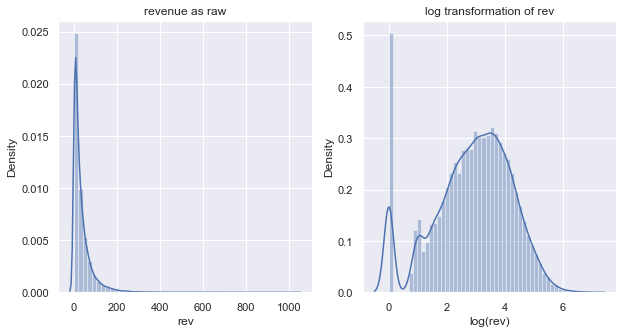

In [264]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(10,5)

sns.distplot(trip_per_day2['rev'], bins = 50, ax = axes[0])
sns.distplot(trip_per_day2['log_rev'], bins = 50, ax = axes[1])

axes[0].set(xlabel = 'rev', title = 'revenue as raw')
axes[1].set(xlabel = 'log(rev)', title = 'log transformation of rev')

In [265]:
trip_per_day2.shape

(30622, 13)

## Data exploration

### Effect of time on the revenue

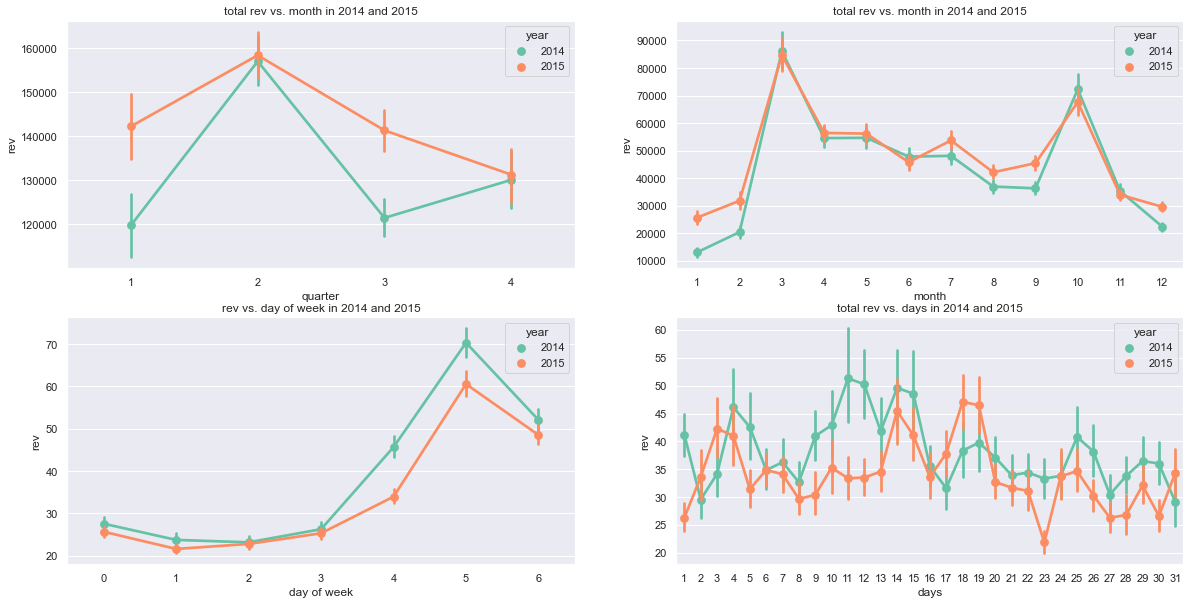

In [267]:
fig,axes = plt.subplots(2,2)
fig.set_size_inches(20, 10)

#time frame:quarter:
sns.pointplot(x = 'quarter', y = 'rev',hue = 'year', estimator = sum, data = trip_per_day2,
              palette="Set2", ax = axes[0,0])


# #time frame: month
sns.pointplot(x = 'month', y = 'rev',hue = 'year', estimator = sum, data = trip_per_day2,
              palette="Set2", ax = axes[0,1])

# #time frame: day of week
sns.pointplot(x='dow', y='rev',hue = 'year', 
              palette="Set2", data = trip_per_day2,ax = axes[1,0])

#time frame: days of month

sns.pointplot(x='day', y='rev',hue = 'year', 
              palette="Set2", data = trip_per_day2,ax = axes[1,1])

axes[0,0].set(xlabel = 'quarter', title = 'total rev vs. month in 2014 and 2015')
axes[0,1].set(xlabel = 'month', title = 'total rev vs. month in 2014 and 2015')
axes[1,0].set(xlabel = 'day of week', title = 'rev vs. day of week in 2014 and 2015')
axes[1,1].set(xlabel = 'days', title = 'total rev vs. days in 2014 and 2015')

fig.savefig('general_trend.png', dpi=100)

This figures shows that quarter 2 is the most profitable quarter. March and October are the two busies months. Weekly, the weekend, particularly Saturday (dow = 5) observes a higher demand compared to the weekday. It also shows that over the period of two years, the amount of total revenue slightly increased in January, Feburary, July -Sep and in December. However, there is no sign of continuing growth in revenue 

### Adding festival time features to the data

[Text(0.5, 0, 'Days in October'),
 Text(0.5, 1.0, 'Daily rev in Oct in 2014 and 2015')]

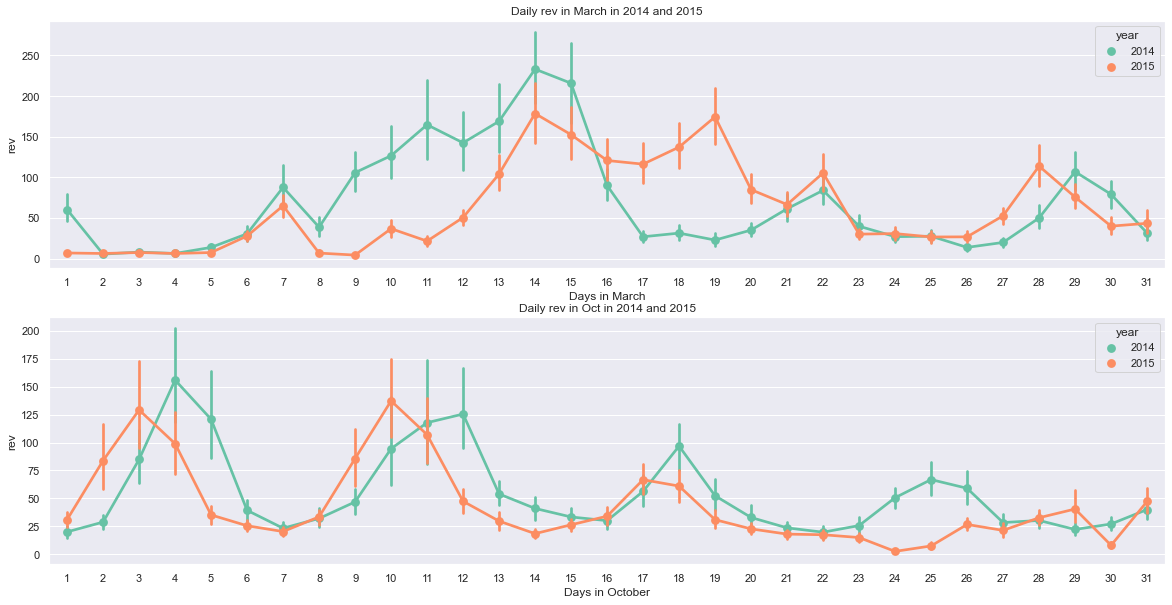

In [268]:
fig,axes = plt.subplots(2,1)
fig.set_size_inches(20, 10)
sns.pointplot(x='day', y='rev',hue = 'year', 
              palette="Set2", data = trip_per_day2[trip_per_day2['month']==3],ax = axes[0])
sns.pointplot(x='day', y='rev',hue = 'year', 
              palette="Set2", data = trip_per_day2[trip_per_day2['month']==10],ax = axes[1])

axes[0].set(xlabel = 'Days in March', title = 'Daily rev in March in 2014 and 2015')
axes[1].set(xlabel = 'Days in October', title = 'Daily rev in Oct in 2014 and 2015')

The figure above shows the trend of total daily revenue change in the two most profitable months, March and October. In March, the rental revenue went high between March 9 to March 18. This period overlaps with the  South by Southwest (SXSW) festival in mid-March, one of Austin's best-known music and film festivals. The highest revenue in October is the first week, which overlaps with the date of another festival in Austin, Austin City Limits Music Festival (ACL). This is a two-weekend music event. 

According to the event website:

- SXSW: 2014-03-07 to 2014-03-16, and 2015-03-13 to 2015-03-22
- ACL: 2014-10-03 to 10-05, 10-10 to 10-12; 2015-10-02 to 10-14, 10-09 to 10-11


These two features were to the data frame

In [269]:
def dlist(start, end):
    d_range = pd.date_range(start, end)
    d_list = [d for d in d_range]
    return d_list

In [270]:
#for training data in 2014-2015
sxsw2014 = dlist('2014-03-07', '2014-03-16')
sxsw2015 = dlist('2015-03-13', '2015-03-22')
sxsw = sxsw2014 + sxsw2015

acl2014_wk1 = dlist('2014-10-03', '2014-10-05')
acl2014_wk2 = dlist('2014-10-10', '2014-10-12')
acl2015_wk1 = dlist('2015-10-02', '2015-10-04')
acl2015_wk2 = dlist('2015-10-09', '2015-10-11')

acl = acl2014_wk1 + acl2014_wk2 + acl2015_wk1 + acl2015_wk2

In [272]:
trip_per_day2['is_sxsw'] = trip_per_day2['date'].apply(lambda x: 1 if x in sxsw else 0)
trip_per_day2['is_acl'] = trip_per_day2['date'].apply(lambda x: 1 if x in acl else 0)

In [273]:
trip_per_day2['is_sxsw'].value_counts()

0    29782
1      840
Name: is_sxsw, dtype: int64

In [274]:
trip_per_day2['is_acl'].value_counts()

0    30064
1      558
Name: is_acl, dtype: int64

In [275]:
#most profitable station
trip_per_day2.groupby(['start_station_name']).agg({'rev':'sum'}).sort_values(['rev'],ascending = False)[:5]

,rev
start_station_name,
Zilker Park,59671.6
Riverside @ S. Lamar,57426.0
City Hall / Lavaca & 2nd,53859.6
2nd & Congress,49689.1
Capitol Station / Congress & 11th,42314.6


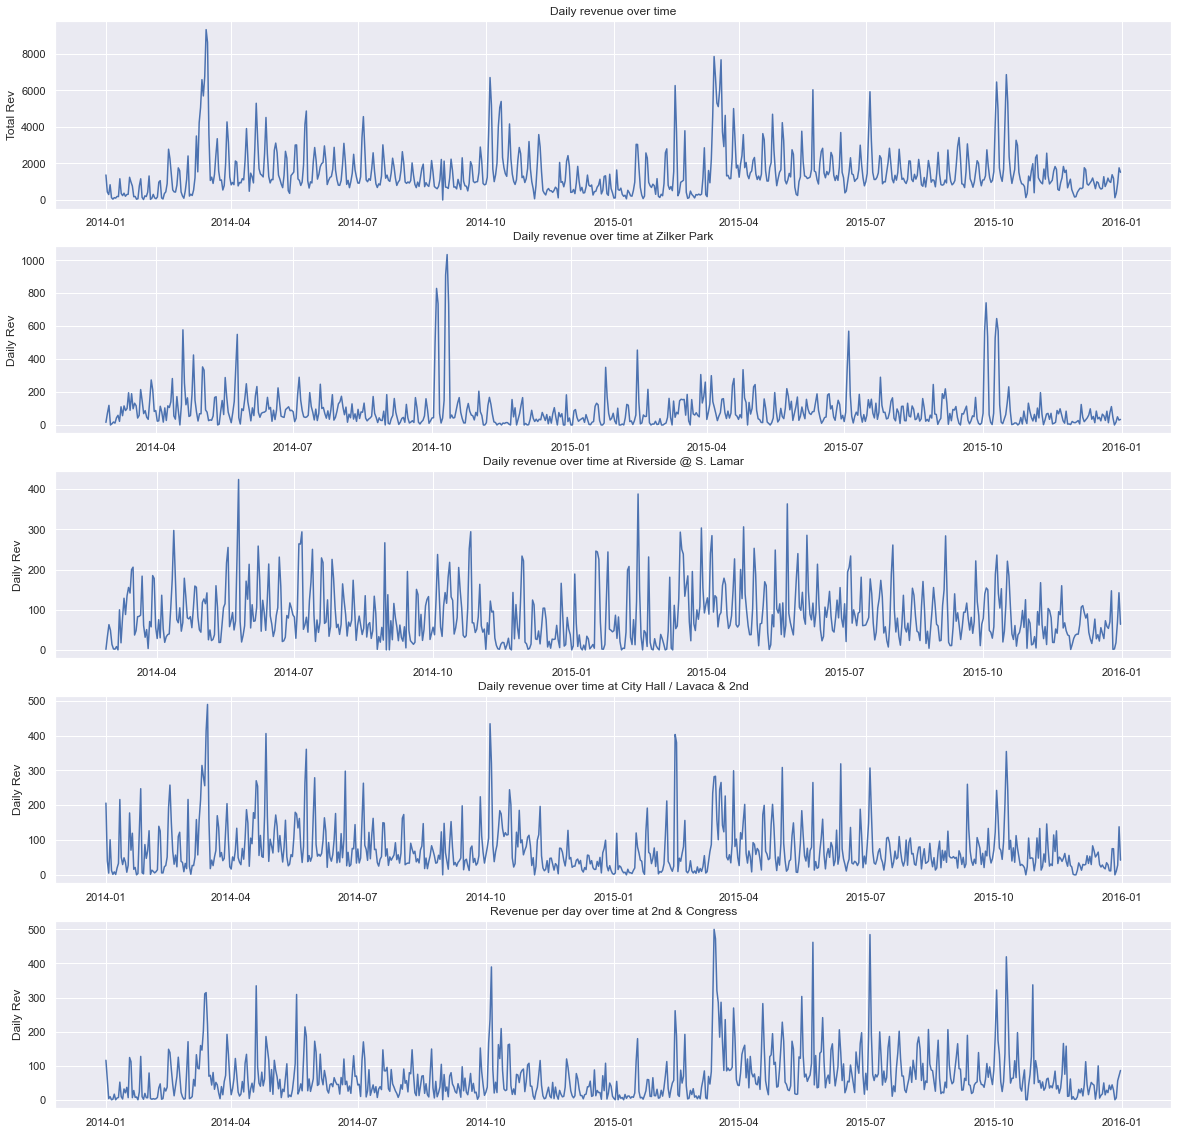

In [498]:
plt.figure(figsize = (20,20))


plt.subplot(5,1, 1)
plt.plot(trip_per_day2.groupby('date').agg({'rev':'sum'}))
plt.title('Daily revenue over time')
plt.ylabel('Total Rev')

plt.subplot(5,1, 2)
plt.plot(trip_per_day2[trip_per_day2['start_station_name']=='Zilker Park']['date'],
         trip_per_day2[trip_per_day2['start_station_name']=='Zilker Park']['rev'])
plt.title('Daily revenue over time at Zilker Park')
plt.ylabel('Daily Rev')

plt.subplot(5, 1, 3)
plt.plot(trip_per_day2[trip_per_day2['start_station_name']=='Riverside @ S. Lamar']['date'],
    trip_per_day2[trip_per_day2['start_station_name']=='Riverside @ S. Lamar']['rev'])
plt.title('Daily revenue over time at Riverside @ S. Lamar')
plt.ylabel('Daily Rev')


plt.subplot(5, 1, 4)
plt.plot(trip_per_day2[trip_per_day2['start_station_name']=='City Hall / Lavaca & 2nd']['date'],
         trip_per_day2[trip_per_day2['start_station_name']=='City Hall / Lavaca & 2nd']['rev'])
plt.title('Daily revenue over time at City Hall / Lavaca & 2nd')
plt.ylabel('Daily Rev')

plt.subplot(5, 1, 5)
plt.plot(trip_per_day2[trip_per_day2['start_station_name']=='2nd & Congress']['date'],
    trip_per_day2[trip_per_day2['start_station_name']=='2nd & Congress']['rev'])
plt.title('Revenue per day over time at 2nd & Congress')
plt.ylabel('Daily Rev')

fig.savefig('total rev for the most profitable station', dpi=100)

The figure above shows the revenue spikes every year near March (SXSW festival) and October (ACL festival) period. 

### Check stationarity and seasonality

In [277]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    fig.savefig('TSAanalysis3.png',dpi = 100)

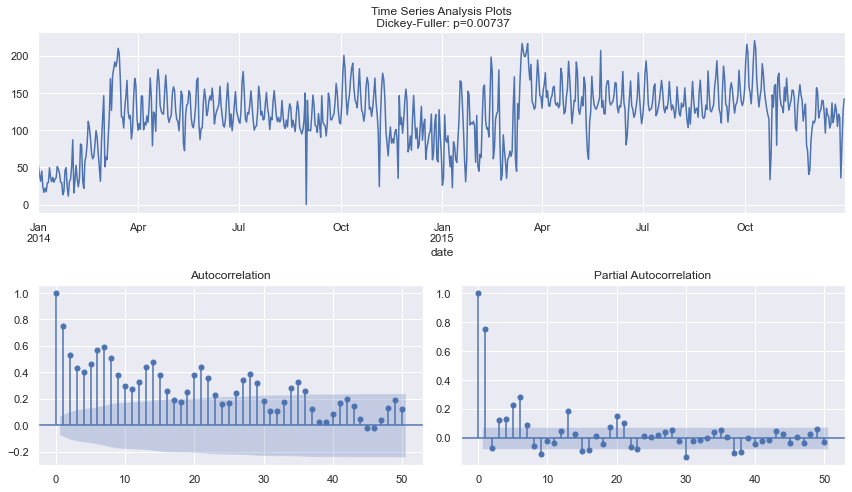

In [278]:
tsplot(trip_per_day2.groupby(['date']).agg({'log_rev':'sum'})['log_rev'],lags = 50)



Clearly, we can see the seasonality trend: the pattern repeat every week (PACF plot). P is below 5%, so the data is stationery

In [ ]:
result = seasonal_decompose(trip_per_day2.groupby(['date']).agg({'rev':'sum'})['rev'], model='additive', freq=7)
fig3 = result.plot()
fig3.set_size_inches(18.5, 10.5)
fig3.savefig('seasonal_decomposition.png', dpi=100)

In [279]:
trip_per_day2.to_csv('bike_trip_df2_xgb.csv')

In [280]:
#=====================Finished bike train data processing=====================#

## Weather data exploration

For the weather events that going to affect the rental rate, they are encoded as 0 (no event) and 1(has event)

In [281]:
weather_df['Events_id'] = weather_df['Events'].apply(lambda x: 0 if x is np.nan else 1)
weather_df = weather_df.drop('Events', axis = 1)

In [282]:
weather_df['Precipitation_Inches'].replace({'T': 0.001},inplace = True)
weather_df['Precipitation_Inches']= pd.to_numeric(weather_df['Precipitation_Inches'])

In [283]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1096 non-null   datetime64[ns]
 1   TempHigh_F            1096 non-null   int64         
 2   TempAvg_F             1096 non-null   int64         
 3   TempLow_F             1096 non-null   int64         
 4   HumidityHigh_Percent  1094 non-null   float64       
 5   HumidityAvg_Percent   1094 non-null   float64       
 6   HumidityLow_Percent   1094 non-null   float64       
 7   VisibilityHigh_Miles  1084 non-null   float64       
 8   VisibilityAvg_Miles   1084 non-null   float64       
 9   VisibilityLow_Miles   1084 non-null   float64       
 10  WindHigh_MPH          1094 non-null   float64       
 11  WindAvg_MPH           1094 non-null   float64       
 12  WindGust_MPH          1093 non-null   float64       
 13  Precipitation_Inch

In [284]:
#fill in the na values with previous non NA values
weather_df = weather_df.ffill()

In [285]:
weather_df = weather_df.set_index('Date',drop= True)

In [286]:
weather_df.rename_axis('date', inplace = True)

In [287]:
weather_df.head()

,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events_id
date,,,,,,,,,,,,,,
2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.0,0
2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.0,0
2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.0,0
2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.0,0
2014-01-05,59,47,34,87.0,59.0,31.0,10.0,10.0,4.0,21.0,10.0,34.0,0.0,0


### Check correlations

<AxesSubplot:>

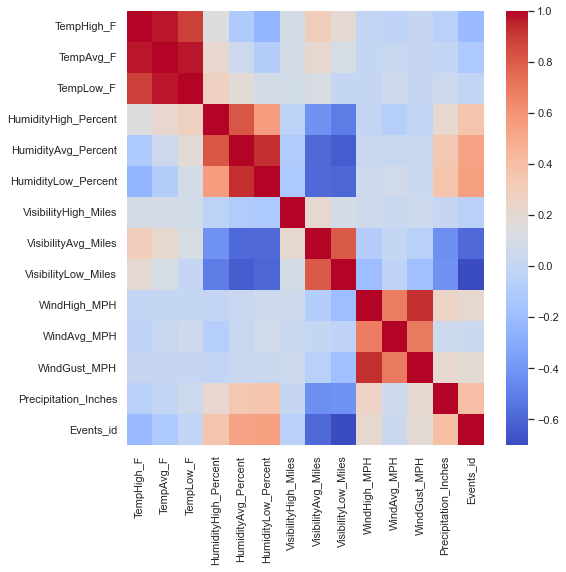

In [288]:
#first, check correlations
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(weather_df.corr(), cmap='coolwarm',ax = ax)

For temperature, humidity, and visibility it seems that the values of high, low and average are highly correlated. 
for the future prediction, only average is used. For Wind, two things, windAvg and WindGust were kept. 

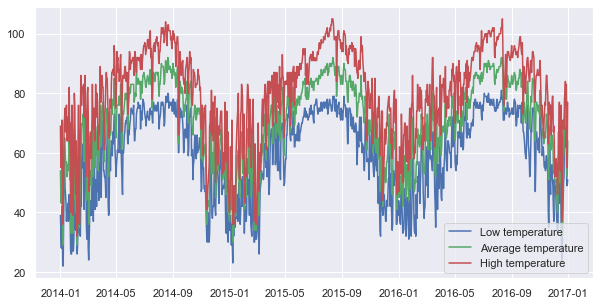

In [289]:
#check tempeature trend over time
# Plot temperatures over time
plt.figure(figsize = (10,5))

plt.plot('TempLow_F', data = weather_df, color='b', label= 'Low temperature')
plt.plot('TempAvg_F' , data = weather_df,color = 'g',label = 'Average temperature')
plt.plot('TempHigh_F' , data = weather_df, color = 'r',label = 'High temperature')
plt.legend();

Text(0, 0.5, 'WindGust')

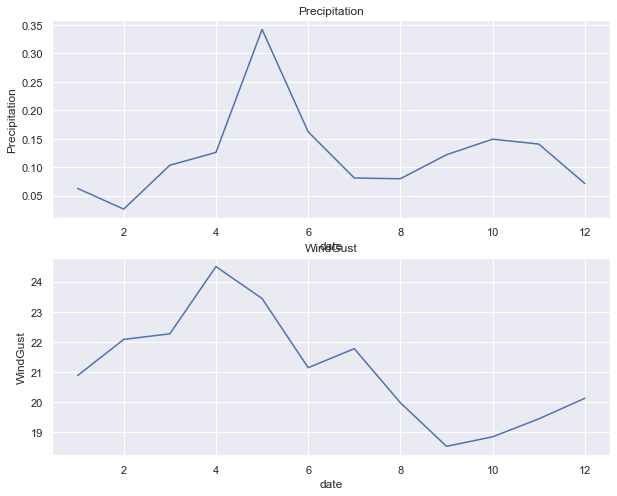

In [292]:
plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
weather_df['Precipitation_Inches'].groupby([weather_df.index.month]).mean().plot()
plt.title('Precipitation')
plt.ylabel('Precipitation')
plt.subplot(2,1,2)
weather_df['WindGust_MPH'].groupby([weather_df.index.month]).mean().plot()
plt.title('WindGust')
plt.ylabel('WindGust')

May rains a lot, while April is a strong windy season. 

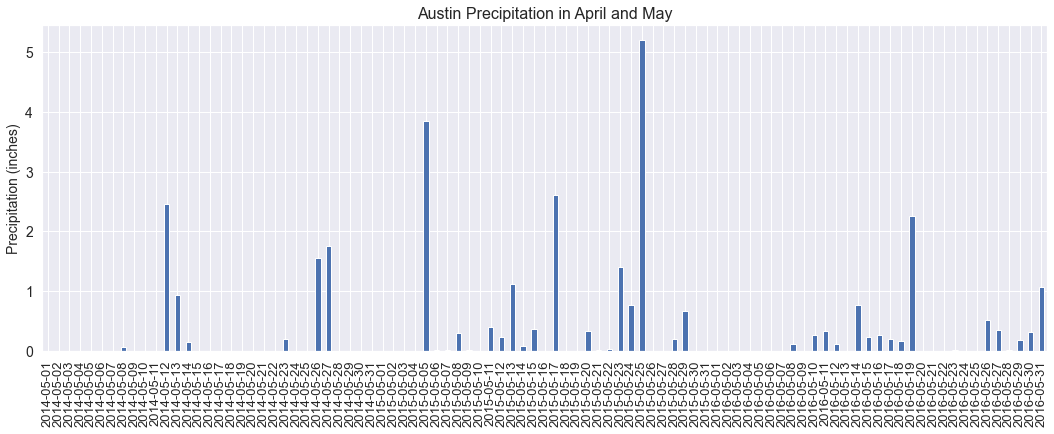

In [455]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
ax = weather_df['Precipitation_Inches'][weather_df.index.month==5].plot.bar(ax=ax, legend=None)
ax.set_xticklabels(weather_df.index.date[weather_df.index.month==5])
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('Precipitation (inches)', fontdict={'size' : 14})
ax.set_title('Austin Precipitation in April and May', fontdict={'size' : 16})
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=14)
ttl = ax.title
ttl.set_position([.5, 1.02])

### Combine the trip and weather information by date

In [302]:
weather_df.columns

Index(['TempHigh_F', 'TempAvg_F', 'TempLow_F', 'HumidityHigh_Percent',
       'HumidityAvg_Percent', 'HumidityLow_Percent', 'VisibilityHigh_Miles',
       'VisibilityAvg_Miles', 'VisibilityLow_Miles', 'WindHigh_MPH',
       'WindAvg_MPH', 'WindGust_MPH', 'Precipitation_Inches', 'Events_id'],
      dtype='object')

In [303]:
trip_per_day2.columns

Index(['start_station_id', 'start_station_name', 'date', 'rev', 'dow',
       'quarter', 'day', 'month', 'year', 'is_holiday', 'Week_sin', 'Week_cos',
       'log_rev', 'is_sxsw', 'is_acl'],
      dtype='object')

In [304]:
tripWeather = pd.merge(trip_per_day2, weather_df, on= 'date', how='left')

In [305]:
tripWeather.sort_values(by = 'date', inplace = True)
tripWeather = tripWeather.set_index('date', drop = True)

In [306]:
tripWeather.shape

(30622, 28)

In [307]:
tripWeather.to_csv('master_df_bike_weather.csv')

In [308]:
#===============Done extract training data feature======================#

In [309]:
#===============start to extract test data feature=========================#

In [310]:
trip_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 1239
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   month               1240 non-null   int64 
 1   day                 1240 non-null   int64 
 2   start_station_name  1240 non-null   object
 3   pred                1240 non-null   int64 
 4   start_station_id    1240 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 58.1+ KB


In [311]:
trip_test2.shape

(1240, 5)

In [312]:
trip_test2['year'] = 2016

In [313]:
trip_test2.head()

,month,day,start_station_name,pred,start_station_id,year
0,1,1,17th & Guadalupe,-1,2540,2016
1,1,1,2nd & Congress,-1,2494,2016
2,1,1,5th & Bowie,-1,2501,2016
3,1,1,8th & Congress,-1,2496,2016
4,1,1,City Hall / Lavaca & 2nd,-1,2499,2016


In [314]:
trip_test2['date']=pd.to_datetime(trip_test2[['year','month','day']])

In [315]:
trip_test3= ts_helper(trip_test2)

In [ ]:
#adding the festival info to test data

In [318]:
#for test data in 2016
sxsw2016 = dlist('2016-03-11', '2016-03-20')
acl2016_wk1 = dlist('2016-09-30', '2016-10-02')
acl2016_wk2 = dlist('2016-10-07', '2016-10-09')
acl2016 = acl2016_wk1 + acl2016_wk2 

In [319]:
trip_test3['is_sxsw'] = trip_per_day2['date'].apply(lambda x: 1 if x in sxsw else 0)
trip_test3['is_acl'] = trip_per_day2['date'].apply(lambda x: 1 if x in acl else 0)

In [320]:
trip_test3.shape

(1240, 14)

In [323]:
trip_test3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 1239
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month               1240 non-null   int64         
 1   day                 1240 non-null   int64         
 2   start_station_name  1240 non-null   object        
 3   pred                1240 non-null   int64         
 4   start_station_id    1240 non-null   int64         
 5   year                1240 non-null   int64         
 6   date                1240 non-null   datetime64[ns]
 7   dow                 1240 non-null   int64         
 8   quarter             1240 non-null   int64         
 9   is_holiday          1240 non-null   int64         
 10  Week_sin            1240 non-null   float64       
 11  Week_cos            1240 non-null   float64       
 12  is_sxsw             1240 non-null   int64         
 13  is_acl              1240 non-null   int64       

In [324]:
testWeather = pd.merge(trip_test3,weather_df, on= 'date', how='left')

In [325]:
testWeather.sort_values(by =['date','start_station_name'], inplace = True)
testWeather = testWeather.set_index('date', drop = True)

In [326]:
testWeather.to_csv('master_test_df_weather.csv')

In [327]:
testWeather.shape

(1240, 27)

## Data preparation

In [328]:
#==================Prepare train and test data for xgboosting==================#

In [329]:
#load the master files
#tripWeather = pd.read_csv('master_df_bike_weather.csv', parse_dates=['date'])
#testWeather = pd.read_csv('master_test_df_weather.csv', parse_dates=['date'])

In [330]:
#tripWeather = tripWeather.set_index('date', drop = True)
#testWeather = testWeather.set_index('date', drop = True)

Some features are categorical variables. In order to fit these features in the regression model, they are dummy coded

In [331]:
#dummy code the categorical variables

month_train = pd.get_dummies(tripWeather['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(testWeather['month'], prefix='m', prefix_sep='_')

dow_train = pd.get_dummies(tripWeather['dow'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(testWeather['dow'], prefix='dow', prefix_sep='_')

day_train = pd.get_dummies(tripWeather['day'], prefix='d', prefix_sep='_')
day_test = pd.get_dummies(testWeather['day'], prefix='d', prefix_sep='_')


quarter_train = pd.get_dummies(tripWeather['quarter'], prefix='q', prefix_sep='_')
quarter_test = pd.get_dummies(testWeather['quarter'], prefix='q', prefix_sep='_')

loc_train = pd.get_dummies(tripWeather['start_station_id'], prefix='loc', prefix_sep='_')
loc_test = pd.get_dummies(testWeather['start_station_id'], prefix='loc', prefix_sep='_')

In [332]:
tripWeather.columns

Index(['start_station_id', 'start_station_name', 'rev', 'dow', 'quarter',
       'day', 'month', 'year', 'is_holiday', 'Week_sin', 'Week_cos', 'log_rev',
       'is_sxsw', 'is_acl', 'TempHigh_F', 'TempAvg_F', 'TempLow_F',
       'HumidityHigh_Percent', 'HumidityAvg_Percent', 'HumidityLow_Percent',
       'VisibilityHigh_Miles', 'VisibilityAvg_Miles', 'VisibilityLow_Miles',
       'WindHigh_MPH', 'WindAvg_MPH', 'WindGust_MPH', 'Precipitation_Inches',
       'Events_id'],
      dtype='object')

Based on the exploratory data analysis, the additional numeric features were chosen to fit in the regression model.

In [335]:
features_in = ['log_rev','is_holiday', 'Week_sin', 'Week_cos','is_sxsw','is_acl',
               'TempAvg_F','HumidityAvg_Percent','VisibilityAvg_Miles','WindAvg_MPH','WindGust_MPH',
            'Precipitation_Inches', 'Events_id']

Then all the features are combined to a train and test dataset

In [336]:
train_dfm1 = pd.concat([tripWeather[features_in],month_train,dow_train,day_train,quarter_train,loc_train], axis = 1)
test_dfm1 = pd.concat([testWeather[features_in[1:]],month_test,dow_test,day_test,quarter_test,loc_test], axis = 1)

In [337]:
train_dfm1.shape,test_dfm1.shape

((30622, 123), (1240, 67))

In [339]:
missing_cols = set(train_dfm1.columns)-set(test_dfm1.columns)
for c in missing_cols:
    test_dfm1[c]=0

In [340]:
train_dfm1.shape,test_dfm1.shape

((30622, 123), (1240, 123))

### Helper functions

In [342]:
def split_helper(df,ycol,test_ratio = 0.25):
    '''
    input: a complete df with features and y
    test_ratio: the ratio of test data
    
    output: X_train, Y_train, X_test, Y_test, with the designed split ratio
    '''
    
    df2= df.copy()
    X = df2.drop([ycol], axis = 1)
    y = df2[ycol]
    test_size = int(len(X) * test_ratio)
    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    return X_train, y_train, X_test, y_test

In [343]:
def plot_forecast(series_train, series_test, forecast):

    rmse = mse(series_test, forecast,squared = False)
    
    plt.figure(figsize=(20, 6))
    plt.title(f'RMSE: {rmse:.3f}', size=18)
    
    plt.plot(series_train.index, series_train,label='train', color='b')
    plt.plot(series_test.index, series_test,label='test', color='g')
    
    yhat = forecast.copy()
    yhat = pd.Series(yhat)
    yhat.index = series_test.index
    
    plt.plot(yhat, label='forecast', color='r')

    plt.legend(prop={"size": 16})
    plt.show()

## XGBoost regression

In [341]:
#=======================fit in XGBoosting model==================


In [344]:
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = split_helper(train_dfm1, 'log_rev',0.25)

In [345]:
X_train_xgb.shape, y_train_xgb.shape, X_test_xgb.shape, y_test_xgb.shape

((22967, 122), (22967,), (7655, 122), (7655,))

### Establish the baseline RMSE

In [509]:

y_hat_ma = []
window_size = 7
  
i = 0
  
# Loop through the array to consider

while i < len(train_dfm1['log_rev']) - window_size + 1:
    
    window = train_dfm1['log_rev'][i : i + window_size]
  
    window_average = round(sum(window) / window_size, 2)
      
    y_hat_ma.append(window_average)
      
    i += 1
  

In [510]:
#baseline MSE:
rmse_b = mse(y_test_xgb, y_hat_ma[-len(y_test_xgb):],squared = False)

In [511]:
print (f'the baseline of the prediction based on moving average is {rmse_b:.3f}')

the baseline of the prediction based on moving average is 0.990


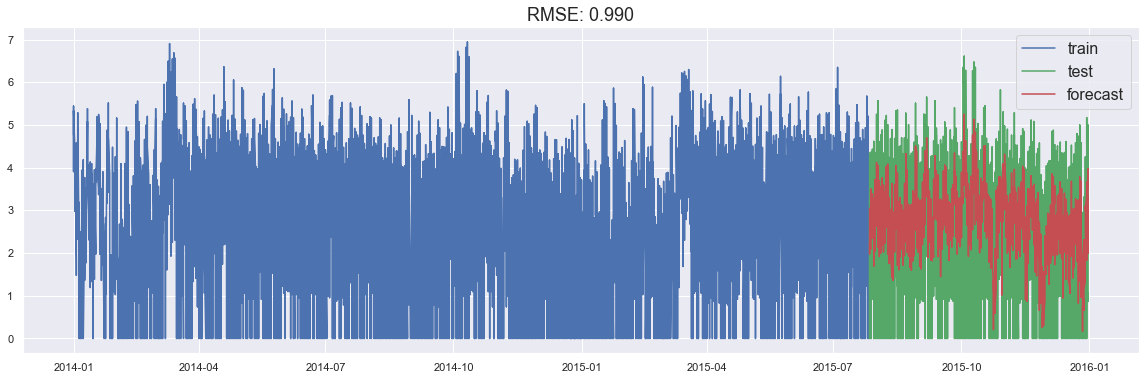

In [512]:
plot_forecast(y_train_xgb,y_test_xgb, y_hat_ma[-len(y_test_xgb):])

In [361]:
xgb_model1 = xgb.XGBRegressor()

In [362]:
xgb_model1.fit(X_train_xgb, y_train_xgb,verbose= 1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [363]:
xgb_pred1 = xgb_model1.predict(X_test_xgb)

In [364]:
rmse_xgb1 = mse(y_test_xgb, xgb_pred1,squared = False)

In [365]:
print (f'The RMSE for xgb1_model1 is {rmse_xgb1:.3f}')

The RMSE for xgb1_model1 is 0.993


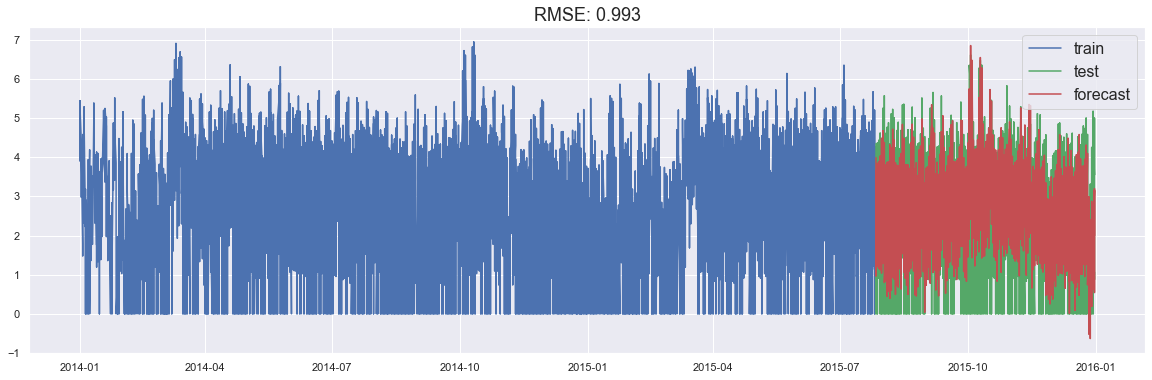

In [366]:
plot_forecast(y_train_xgb,y_test_xgb, xgb_pred1)

In [491]:
loc_train = (X_train_xgb['loc_2501']==1)
loc_test = (X_test_xgb['loc_2501']==1)

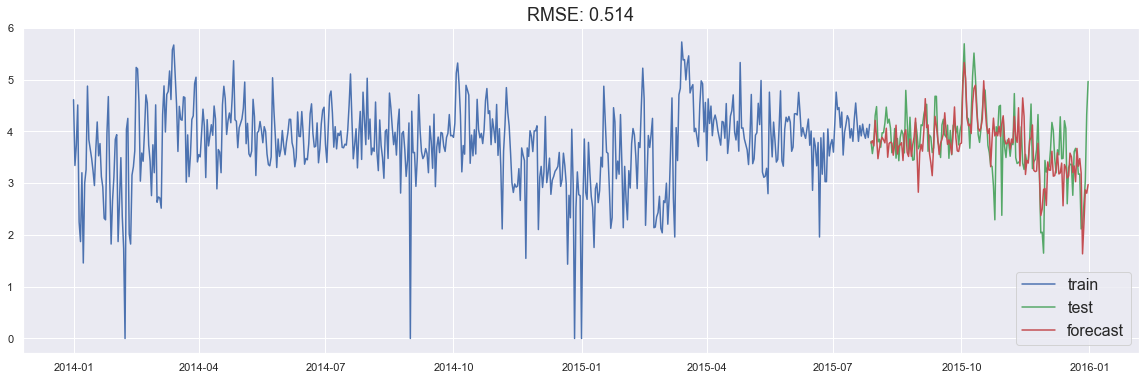

In [492]:
plot_forecast(y_train_xgb[loc_train],y_test_xgb[loc_test], xgb_pred1[loc_test])

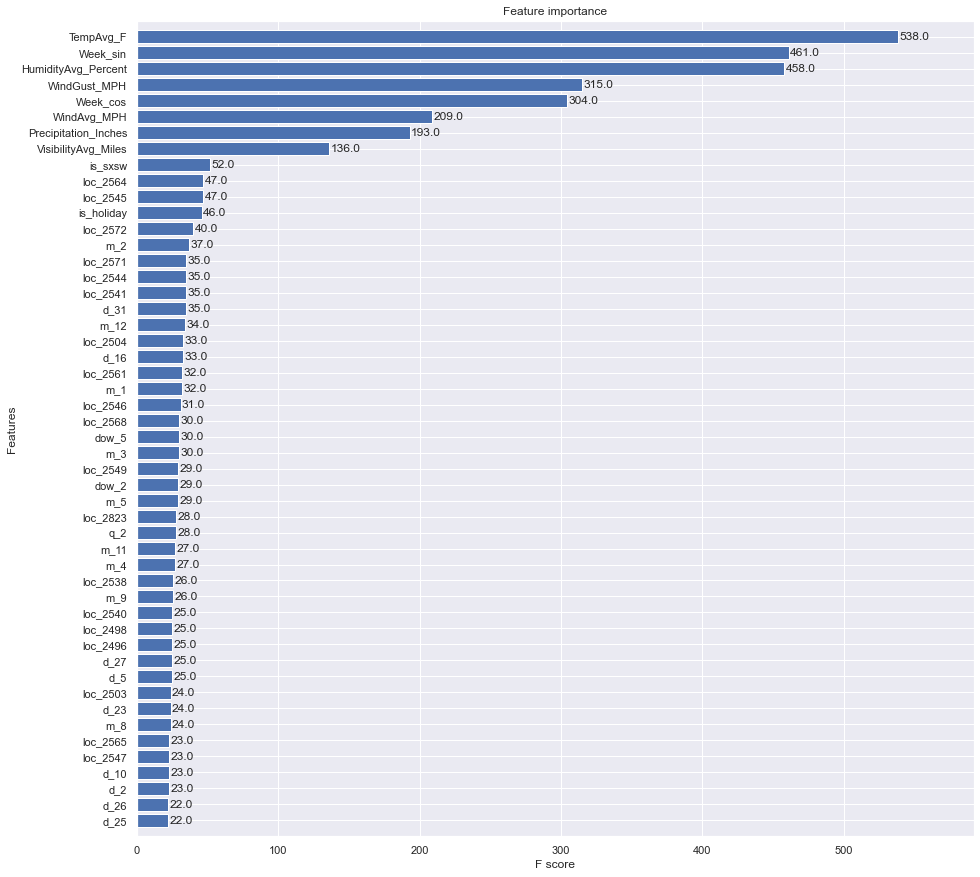

In [519]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgb_model1, max_num_features=50, height=0.8,ax = ax)
plt.show()

### Tuning hyperparameters

In [370]:
#grid tunning the hyper parameters


In [371]:
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}


xgb_model2 = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid_xgb = GridSearchCV(xgb_model2, params, verbose = 1)
grid_xgb.fit(X_train_xgb, y_train_xgb)
gridcv_xgb = grid_xgb.best_estimator_




Fitting 5 folds for each of 450 candidates, totalling 2250 fits


In [372]:
print(f'The best model is with RMSE: {mse(y_test_xgb, gridcv_xgb.predict(X_test_xgb),squared = False):.3f}')

The best model is with RMSE: 0.956


In [373]:
xgb_pred2 = gridcv_xgb.predict(X_test_xgb)

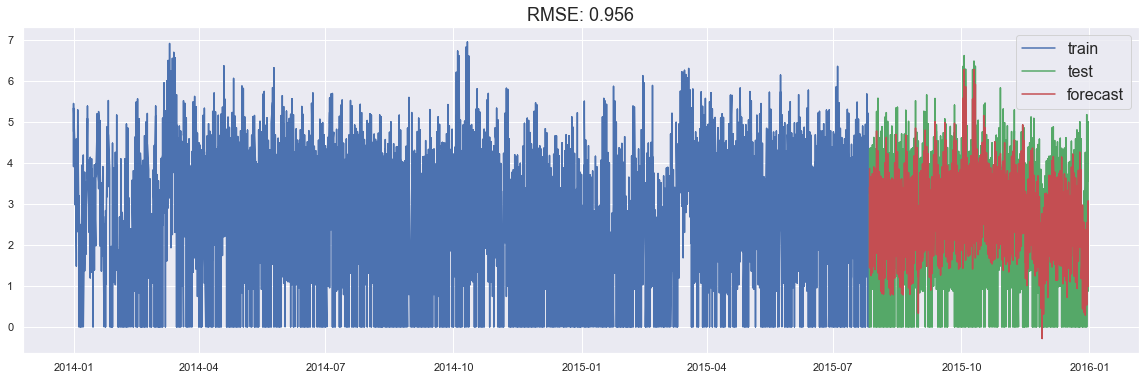

In [374]:
plot_forecast(y_train_xgb,y_test_xgb, xgb_pred2)

In [489]:
loc_train = (X_train_xgb['loc_2501']==1)
loc_test = (X_test_xgb['loc_2501']==1)

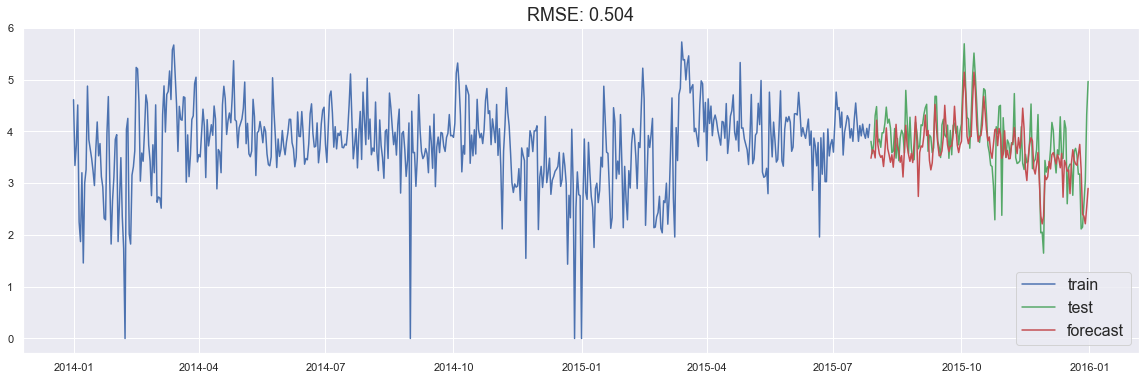

In [490]:
plot_forecast(y_train_xgb[loc_train],y_test_xgb[loc_test], xgb_pred2[loc_test])

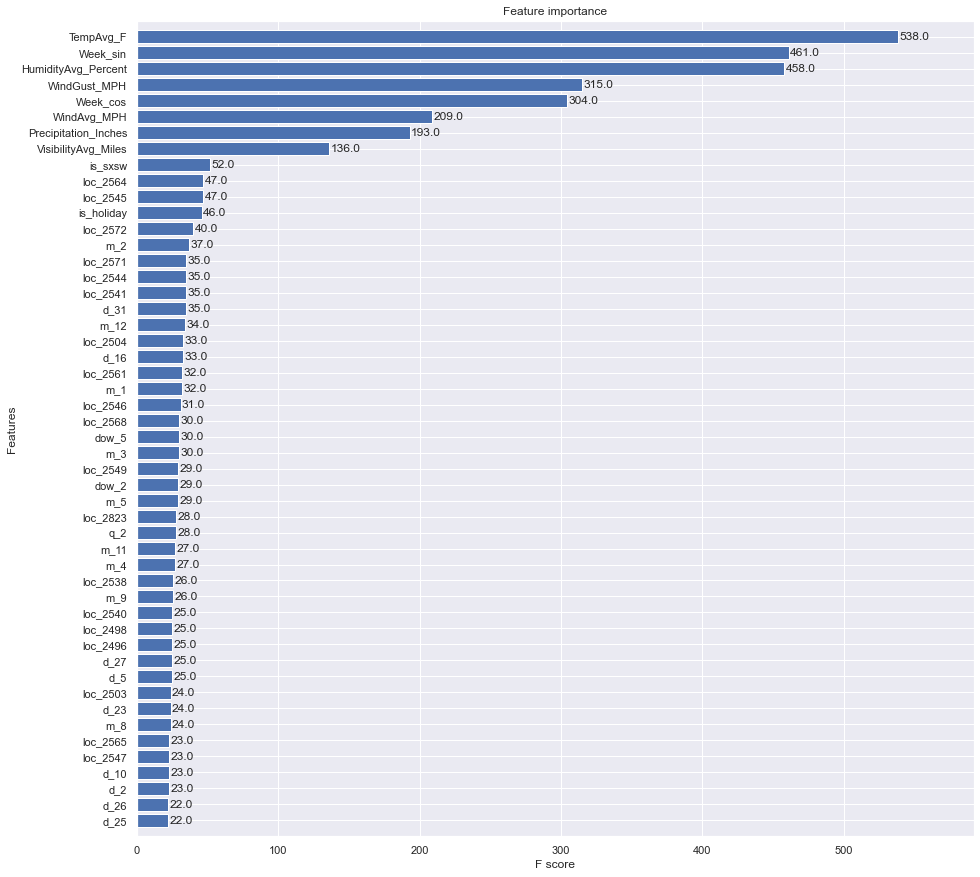

In [518]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgb_model1, max_num_features=50, height=0.8,ax = ax)
plt.show()

## Prediction of 2016 revenue

In [500]:
test_dfm1.shape

(1240, 123)

In [436]:
X_test_fv = test_dfm1.copy()

In [437]:
X_test_fv.drop('log_rev', axis = 1, inplace = True)

In [438]:
y_test_fv = gridcv_xgb.predict(X_test_fv)

In [439]:
df_sub = trip_test2.copy()

In [440]:
df_sub['pred_log_rev'] = y_test_fv

In [442]:
df_sub['pred'] = np.exp(df_sub['pred_log_rev'])-1

In [485]:
df_sub.head(10)

,month,day,start_station_name,pred,start_station_id,year,date,pred_log_rev
0,1,1,17th & Guadalupe,9.609506,2540,2016,2016-01-01,2.361750
1,1,1,2nd & Congress,8.070605,2494,2016,2016-01-01,2.205039
2,1,1,5th & Bowie,9.126348,2501,2016,2016-01-01,2.315141
3,1,1,8th & Congress,9.126348,2496,2016,2016-01-01,2.315141
4,1,1,City Hall / Lavaca & 2nd,9.126348,2499,2016,2016-01-01,2.315141
5,1,1,Convention Center / 3rd & Trinity,9.126348,2498,2016,2016-01-01,2.315141
6,1,1,Davis at Rainey Street,9.126348,2563,2016,2016-01-01,2.315141
7,1,1,Guadalupe & 21st,9.126348,2547,2016,2016-01-01,2.315141
8,1,1,South Congress & Academy,4.515480,2570,2016,2016-01-01,1.707559
9,1,1,West & 6th St.,9.126348,2537,2016,2016-01-01,2.315141


<AxesSubplot:xlabel='pred', ylabel='Density'>

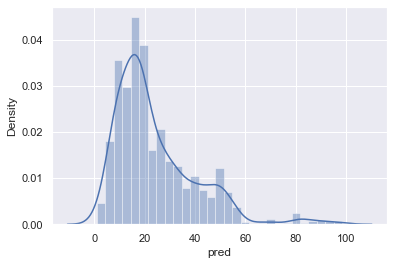

In [443]:
sns.distplot(df_sub['pred'])

Text(0, 0.5, 'Total Rev')

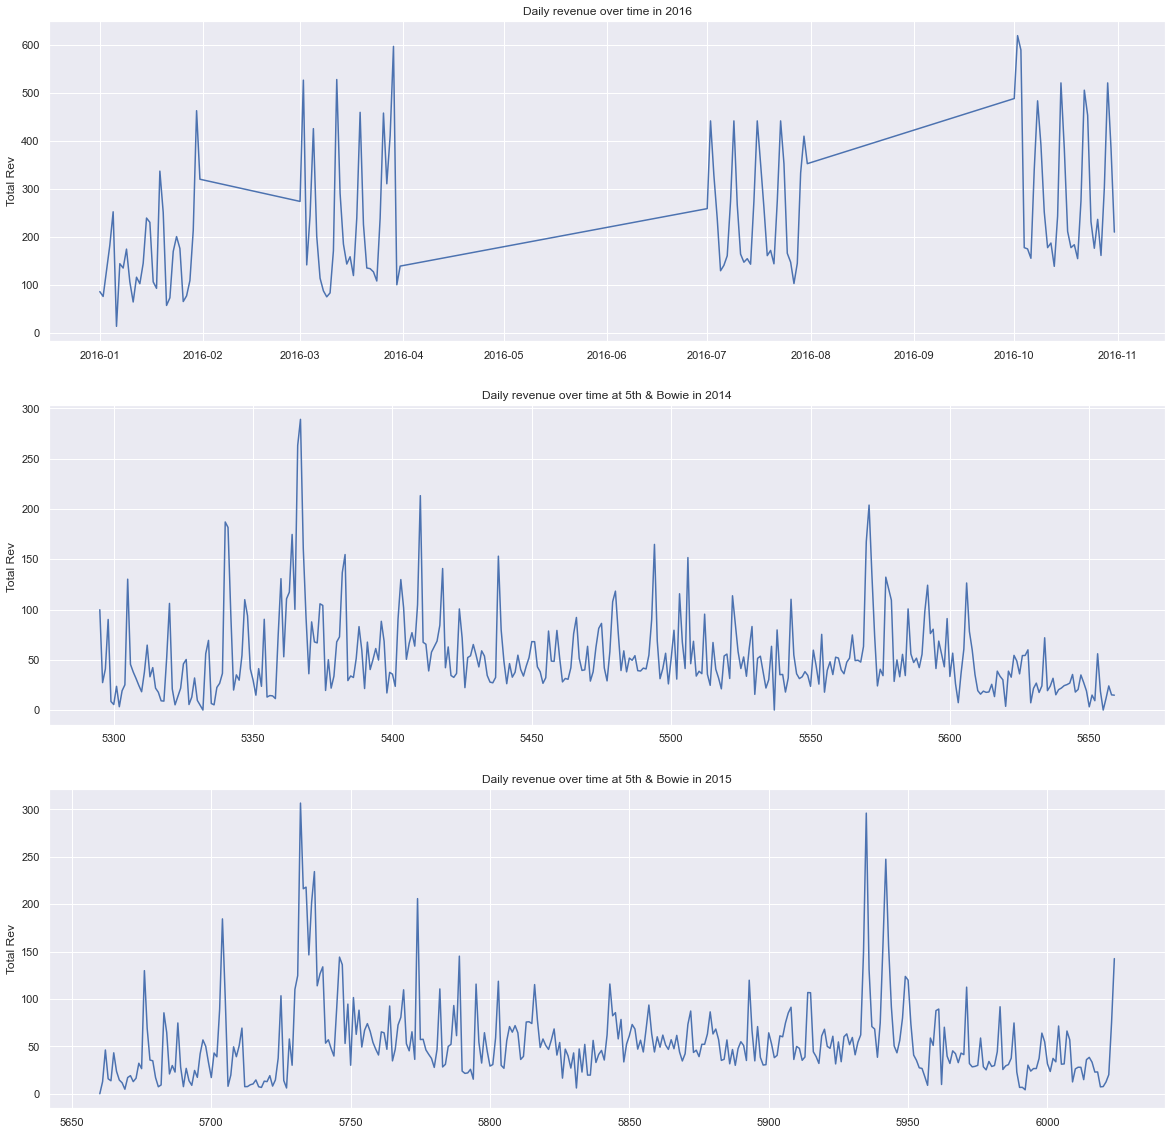

In [495]:
plt.figure(figsize = (20,20))


plt.subplot(3,1, 1)
plt.plot(df_sub.groupby(['date']).agg({'pred':'sum'})['pred'])
plt.title('Daily revenue over time in 2016')
plt.ylabel('Total Rev')

plt.subplot(3,1, 2)
plt.plot(trip_per_day2[(trip_per_day2['start_station_id']==2501) & (trip_per_day2['year']==2014)]['rev'])
plt.title('Daily revenue over time at 5th & Bowie in 2014')
plt.ylabel('Total Rev ')

plt.subplot(3,1, 3)
plt.plot(trip_per_day2[(trip_per_day2['start_station_id']==2501) & (trip_per_day2['year']==2015)]['rev'])
plt.title('Daily revenue over time at 5th & Bowie in 2015')
plt.ylabel('Total Rev')

### Submission

In [449]:
sub_fv = df_sub[['month','day','start_station_name','pred']]

In [450]:
sub_fv.to_csv('predictions_tt.csv', header=False, index=False)